In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
from pyfaidx import Fasta
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

## Same analysis as before but now we only care about the AAs existing at all instead of belonging to the same gene

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [4]:
p_df = pd.read_csv(proc_cfg(config['lr']['poder_protein']['protein']['summary'], od), sep='\t')
p_df = p_df.merge(mt_df[['associated_gene_biotype', 'structural_category', 'isoform', 'associated_gene']],
                  how='left',
                  left_on='tid', 
                  right_on='isoform')
p_df.rename({'associated_gene':'gid',
             'protein_sequence':'seq'}, axis=1, inplace=True)
assert len(p_df.loc[p_df.isoform.isnull()]) == 0

## First, need to filter

In [5]:
# remove NMD things
p_df = p_df.loc[p_df.protein_is_nmd == False]

# keep only things w/ full ORFs
p_df = p_df.loc[(p_df.protein_has_start_codon==True)&\
                (p_df.protein_has_stop_codon==True)]

# keep only things from annotated protein coding genes
p_df = p_df.loc[p_df.associated_gene_biotype=='Protein Coding']

# length minimum?? maybe not
print(len(p_df.index))

86332


## How many novel AA sequences do we add?

In [8]:
# get annotated AA sequences
fasta_file = proc_cfg(config['ref']['pc'], od)
fasta = Fasta(fasta_file)

# Extract each entry's name and sequence
ref_orfs = {
    "name": [entry.name for entry in fasta],
    "seq": [str(entry) for entry in fasta]
}

ref_orfs = pd.DataFrame(ref_orfs)
ref_orfs['gid'] =  ref_orfs.name.str.split('|', expand=True)[2]
ref_orfs = ref_orfs[['seq']]
ref_orfs['annot_aa'] = True
ref_orfs.drop_duplicates(inplace=True)

In [10]:
# what are novel AA? 
# p_df.loc[p_df.blastp_identity==100][['tid','protein_splice_category']].groupby('protein_splice_category').nunique().rename({'tid':'n_tid'}, axis=1)

# just going to call novel aas as those that are not in the 
# pc translations gencode file
print(len(p_df))
p_df = p_df.merge(ref_orfs, how='left', on=['seq'])
print(len(p_df))
p_df['annot_aa'] = p_df['annot_aa'].fillna(False)

86332
86332


In [11]:
p_df[['perfect_blast_match', 'annot_aa', 'tid']].groupby(['annot_aa', 'perfect_blast_match']).nunique()

tid
annot_aa perfect_blast_match       
False    False                20937
         True                 24773
True     False                   66
         True                 40556

In [12]:
p_df[['seq', 'annot_aa']].groupby('annot_aa').nunique().rename({'seq': 'n_aa'}, axis=1)

,n_aa
annot_aa,
False,38873
True,28043


In [13]:
# how many unique novel AAs do we add per gene?
temp = p_df[['seq', 'annot_aa', 'gid']].groupby(['gid', 'annot_aa']).nunique().reset_index().rename({'seq':'n_aa'}, axis=1)

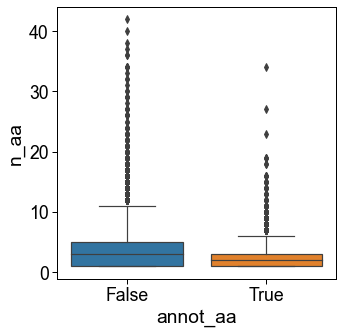

In [14]:
init_plot_settings(aspect='square')
ax = sns.boxplot(temp, y='n_aa', x='annot_aa')

In [15]:
# mean number of added AAs per protein coding gene
temp[['n_aa', 'annot_aa']].groupby('annot_aa').mean()

,n_aa
annot_aa,
False,3.883714
True,2.171923


## How many novel AA sequences do we add?

In [16]:
# how many total novel AAs do we add? how many do we detect? how many were already annotated?
# bar plot
temp = p_df[['seq']].drop_duplicates()
temp['PODER'] = True

temp2 = ref_orfs[['seq']].drop_duplicates()
temp2['GENCODE v47'] = True

temp = temp.merge(temp2, 
                  how='outer',
                  on='seq')
temp.fillna(False, inplace=True)
temp.set_index(['GENCODE v47', 'PODER'], inplace=True)


# temp2 = temp.groupby(['annot_aa']).nunique().reset_index().rename({'aa_id':'n_aa'},axis=1)
# temp2['PODER'] = True

# ref_orfs['aa_id'] = ref_orfs.gid+'_'+ref_orfs.seq

# n = len(ref_orfs.aa_id.unique())
# temp = pd.DataFrame().from_dict({'annotation':['GENCODE v47'], 'n_aa':[n]})
# temp['GENCODE v47'] = True
# temp2 = pd.concat([temp, temp2], axis=0)
# temp2[['n_aa', 'GENCODE v47', 'PODER']]

# temp2.fillna(False, inplace=True)
# temp2.set_index(['GENCODE v47', 'PODER'], inplace=True)
# temp2 = temp2[['n_aa']]

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

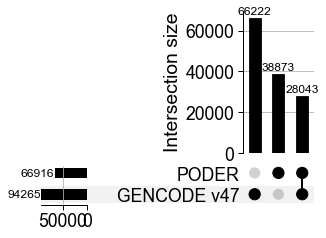

In [17]:
init_plot_settings(aspect='rectangle', font_scale=1)
plt.rcParams.update({'font.size': 12})
upsetplot.plot(temp, sort_by='cardinality', show_counts=True)


## What novelty categories are novel ORFs from generally? 

<AxesSubplot:xlabel='structural_category', ylabel='count'>

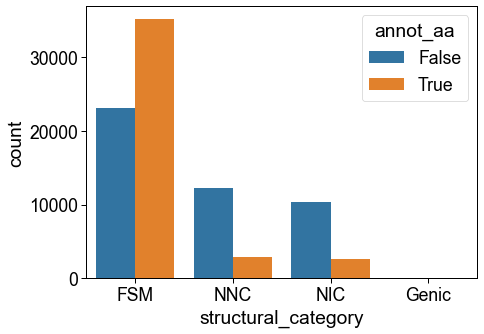

In [18]:
c_dict, order = get_novelty_colors()
temp = p_df[['tid',  'structural_category',
      'annot_aa']]
# .groupby(['structural_category', 'annot_aa']).nunique().rename({'tid':'n_t'}, axis=1).reset_index()

# g = sns.FacetGrid(temp, col='annot_aa')
# g.map(sns.countplot, x='structural_category', palette=c_dict, order=order)
sns.countplot(temp, hue='annot_aa', x='structural_category')